# Predicting Pisa test scores based on socioeconomic indicators

<br>The Pisa test is an annual test consisting of math, science and readind made to evaluate the education systems in countries around the world. The test is known for being a good way for countries to measure and improve their educational policies.
<br>
<br> The idea for this project is to use countries socioeconomic indicators to predict it's result on the Pisa test. The approach used was to take socioeconomic indexes like HDI and GDP per Capita, and add some unusual ones that could have an interesting result if they ended being good variables, example of this are the happiness index and the beer per capita.
<br>
<br> The indicators that will be featured are:
<br>
- HDI: which measures the human development of a country taking into consideration their life expectancy, education and per capita income
- Education index: which measures the education attainment using the adult literacy and the expected school enrollment.
- GDP per Capita: which measures the gross domestic product of a country divided per person.
- Corruption perception index: which measures the perceived corruption determined by experts in the field, with 100 meaning the country is very clean and 0 very corrupt
- Happiness score: which measures the national happiness of a country. This indicator was used to see if being happy can lead to higher grades.
- Beer per Capita: which measures the amount of beer consumed by person in a year. The idea behind including this indicator was to see if countries who consume more alcohol have worse grades.

In [1]:
#packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
from urllib.request import urlopen
import seaborn as sns
from sklearn import linear_model
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Data Cleaning ###

<br>The data for this project comes from different resources, first the test results, happiness score and beer per Capita all come from different csv files, while the education, corruption index and the GDP per Capita will be scrapped from their Wikipedia page.
<br> 
<br>The csv file will be edited so only the columns that will be used in the project are kept, while some columns need to have their data type changed and values that have wrong capitalization or are bad formatted edited.
<br>
<br>The problem with the test data is that the test is not made in all the countries and that there is no average grade. So first an average grade for the test will be calculated for each country and then it's indicators will be scrapped.
<br>
<br>One premise is that the data is comes from a good resource, it's well recorded and there are no mistakes in it, also high result in an indicator will be considered as normal variance of the data and will be kept for the analysis.

In [2]:
#loading and selecting the columns
df1=pd.read_csv("dx.csv")
df1=df1[["Country2","variable","value"]]
countries=df1["Country2"].unique()

#average grade for the test
grades=[]
for country in countries:
    avg=np.mean(df1["value"][df1["Country2"]==country])
    math=df1["value"][(df1["variable"]=="Math") & (df1["Country2"]==country)]
    read=df1["value"][(df1["variable"]=="Read") & (df1["Country2"]==country)]
    science=df1["value"][(df1["variable"]=="Science") & (df1["Country2"]==country)] 
    grades.append([country,round(avg,2),float(math),float(read),float(science)])
    
results=pd.DataFrame(grades,columns=["Country","avg grade","math","read","science"])

In [3]:
#loading the csv and selecting the columns
df2=pd.read_csv("2015.csv")
df2=df2[["Country","Happiness Score"]]

#filteing the countries
df2=df2[df2["Country"].isin(countries)]

In [4]:
#loading the csv and selecting the columns
df3=pd.read_csv("HappinessAlcoholConsumption.csv")
df3=df3[["Country","Region","Hemisphere","HDI","Beer_PerCapita"]]
                
#Correcting the capitalization and typing mistakes
#countries that were capitalized as both(Brazil, Colombia, Ecuador,Peru and Kenya), will be renamed as south, given that this
#countries have normally recognized as being in the south
hemisphere={"north":"North","noth":"North","south":"South","both":"South"}
df3["Hemisphere"]=df3["Hemisphere"].map(hemisphere)

#renaming the columns
to_rename={"Beer_PerCapita":"Beer per Capita"}
df3=df3.rename(columns=to_rename)

#filtering the countries
df3=df3[df3["Country"].isin(countries)]

In [5]:
#scraping the education index
url="https://en.wikipedia.org/wiki/Education_Index#2015"
html=urlopen(url)
soup=BeautifulSoup(html,"html.parser")

data=[]
table=soup.find("table",class_="wikitable sortable")
for row in table.find_all("tr"):
    cells=row.find_all("td")
    try:
        country=row.find("td",align="left").get_text().replace("\xa0","").replace("\n","")
    except AttributeError:
        pass
    if len(cells)==6:
        item=cells[2].find(text=True)
        data.append([country,item])
        
df4=pd.DataFrame(data,columns=["Country","Education"])

#filtering the countries
df4=df4[df4["Country"].isin(countries)]

#changing the data type
df4["Education"]=df4["Education"].astype(float)

In [6]:
#scraping the Corruption Perception index
url="https://en.wikipedia.org/wiki/Corruption_Perceptions_Index"
html=urlopen(url)
soup=BeautifulSoup(html,"html.parser")

data=[]
table=soup.find("table",class_="wikitable sortable")
for row in table.find_all("tr"):
    cells=row.find_all("td")
    try:
        country=row.find("td",style="text-align:left;").get_text().replace("\xa0","").replace("\n","")
    except AttributeError:
        pass
    if len(cells) == 15:
        item=cells[2].find(text=True)
        data.append([country,item])
        
df5=pd.DataFrame(data,columns=["Country","Corruption"])

#filtering the countries
df5=df5[df5["Country"].isin(countries)]

#changing the data type
df5.Corruption=df5.Corruption.astype(int)

In [7]:
#scraping the GDP per Capita
url="https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)_per_capita"
html=urlopen(url)
soup=BeautifulSoup(html,"html.parser")

data=[]
table=soup.find("table",class_="wikitable sortable")
for row in table.find_all("tr"):
    cells=row.find_all("td")
    try:
        country=row.find("td",align="left").get_text().replace("\xa0","").replace("\n","")
    except AttributeError:
        pass
    if len(cells) == 3:
        item=cells[2].find(text=True).replace("\n","").replace(",",".")
        data.append([country,item])
        
df6=pd.DataFrame(data,columns=["Country","GDP per Capita"])

#filtering the countries
df6=df6[df6["Country"].isin(countries)]

#changing the data type
df6["GDP per Capita"]=df6["GDP per Capita"].astype(float)

In [8]:
#merging all the df's
merge=pd.merge(df2,df3,on="Country")
merge=pd.merge(merge,df4,on="Country")
merge=pd.merge(merge,df5,on="Country")
merge=pd.merge(merge,df6,on="Country")
df=pd.merge(results,merge,on="Country")
df.head()

,Country,avg grade,math,read,science,Happiness Score,Region,Hemisphere,HDI,Beer per Capita,Education,Corruption,GDP per Capita
0,Albania,415.21,413.16,405.26,427.22,4.959,Central and Eastern Europe,North,782,89,0.715,36,13.345
1,Australia,502.26,493.90,502.90,509.99,7.284,Australia and New Zealand,South,938,261,0.939,77,52.373
2,Austria,492.22,496.74,484.87,495.04,7.200,Western Europe,North,906,279,0.820,76,52.137
3,Belgium,502.50,506.98,498.52,502.00,6.937,Western Europe,North,915,295,0.841,75,48.245
4,Bulgaria,439.56,441.19,431.72,445.77,4.218,Central and Eastern Europe,North,810,231,0.778,42,23.156


This is how the final database looks like, with the indicators that will be used in the model and some features that will be used in the descriptive analysis of the average grade

### Descriptive Analysis

<br> The objective of plotting the grades is to have a easy visualization of the best and worst performers in the tests, while this is not the main objective of this project, it is a significant part in giving meaning to the existing data.
<br> For this analysis the countries grades in each of the tests will be accessed and split into regions, to see if regions have similar performances or if there are higher performing locations.

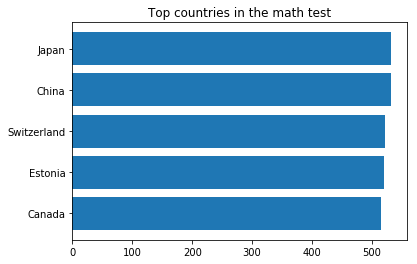

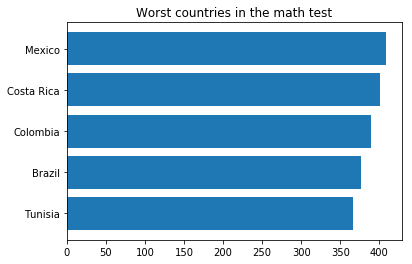

In [9]:
#plotting the grades per subject and average
df_m=df.sort_values("math")
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.barh(df_m["Country"][-6:-1],df_m["math"][-6:-1])
ax1.set_title("Top countries in the math test")
plt.show()

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.barh(df_m["Country"][0:5],df_m["math"][0:5])
ax1.set_title("Worst countries in the math test")
plt.show()

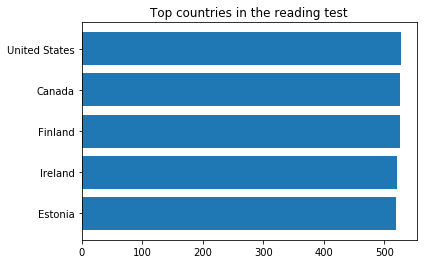

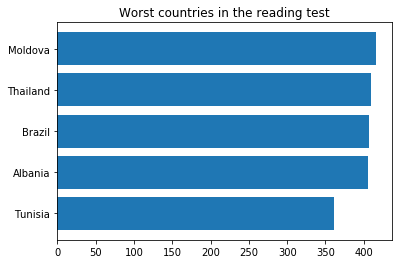

In [10]:
#plotting the reading grade

df_m=df.sort_values("read")

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.barh(df_m["Country"][-6:-1],df_m["read"][-6:-1])
ax1.set_title("Top countries in the reading test")
plt.show()

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.barh(df_m["Country"][0:5],df_m["read"][0:5])
ax1.set_title("Worst countries in the reading test")
plt.show()

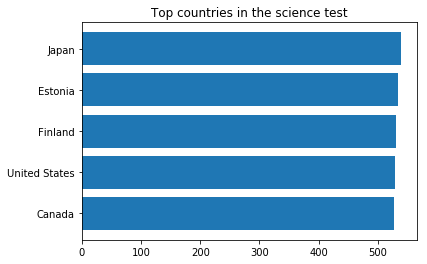

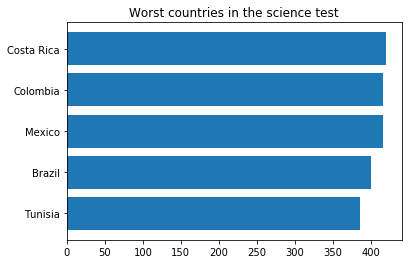

In [11]:
df_m=df.sort_values("science")
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.barh(df_m["Country"][-6:-1],df_m["science"][-6:-1])
ax1.set_title("Top countries in the science test")
plt.show()

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.barh(df_m["Country"][0:5],df_m["science"][0:5])
ax1.set_title("Worst countries in the science test")
plt.show()

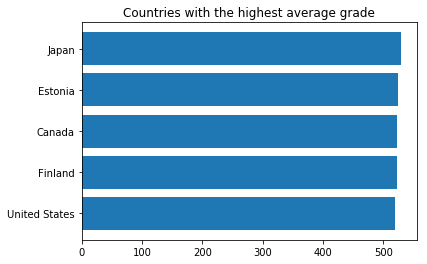

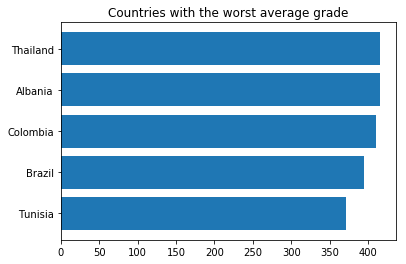

In [12]:
df_m=df.sort_values("avg grade")
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.barh(df_m["Country"][-6:-1],df_m["avg grade"][-6:-1])
ax1.set_title("Countries with the highest average grade")
plt.show()

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.barh(df_m["Country"][0:5],df_m["avg grade"][0:5])
ax1.set_title("Countries with the worst average grade")
plt.show()

The same pattern can be seen in all of the graphs above, the countries with the highest grades are well developed countries from North America, Europe and Asia that have high GDP, HDI and Education levels, while the countries with the lowest grades are from places with worse indicators like South America, Africa Southeast Asia and Eastern Europe

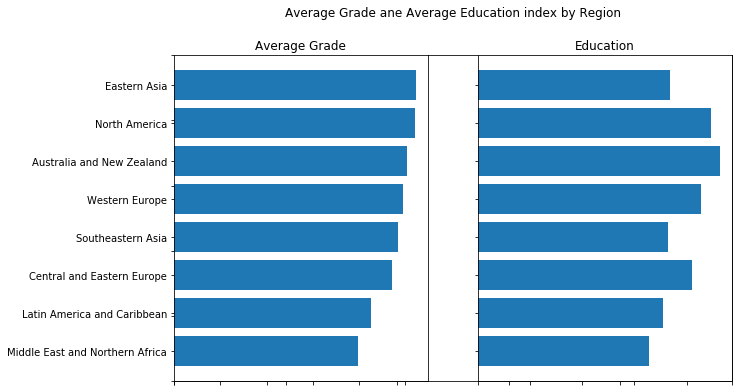

In [13]:
#grade by region

#getting the average grade for each region
regions=df.groupby("Region")["avg grade"].mean()
regions=regions.sort_values()

education=df.groupby("Region")["Education"].mean()
education=education.reindex(regions.index)

#plotting the grade by region
fig=plt.figure(figsize=(10,6))
plt.title("Average Grade ane Average Education index by Region",y=1.1)
plt.gca().set_yticklabels("")
plt.gca().set_xticklabels("")

ax1=fig.add_subplot(121)
ax1.barh(regions.index,regions)
ax1.set_title("Average Grade")
ax1.set_xticklabels("")

ax2=fig.add_subplot(122)
ax2.barh(education.index,education)
ax2.set_title("Education")
ax2.set_yticklabels("")
ax2.set_xticklabels("")

plt.show()

After the analysis from the highest and lowest grades clearly showed that there is significant difference in the grades between countries from various regions, so the appropriate measure was to compare the regions average grade and its education index.
<br>
<br>The first notable result comes from the fact that the highest average grade doesn't come from the region with the highest education index, this can happen because countries from Eastern Asia like China and South Korea have an educational method focused on high grades and test results, but it lacks on encouraging others characteristics like creativity and practical abilities. The result is that their education doesn't have the highest result, but their grades are the highest ones.
<br>
<br>On the other hand the region with the lowest average grade was Middle East and Northern Africa which was also the one with the worst education index, but this can be also a factor that this region is behind in many other indicators like HDI and GDP, so the problems may not be education specific but can range from many different areas.

### Predicting the test grade

To elaborate the model, the first step was to conclude which variables are more relevant. The first step was to see which are the highest correlated variables, so with this in mind the correlation matrix was made.
<br>
<br> The next step was to start making the model and seeing which variables made the model more significant and robust.

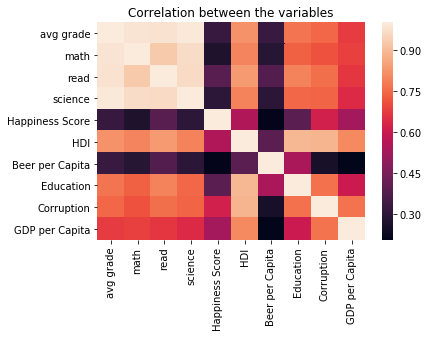

In [14]:
#creating the correlation matrix
corr=df.corr()
plt.title("Correlation between the variables")
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.index)
plt.show()

The highest correlated variables with average grade are Education index, GDP per Capita, Corruption index and HDI. These variables can also be considered the ones with highest relevance for a country possible high grade in the test between the ones studied, so they will be used the model.

The first step was to see if the chosen variables have a linear relationship and if a log transformation can be used to improve its linearity.

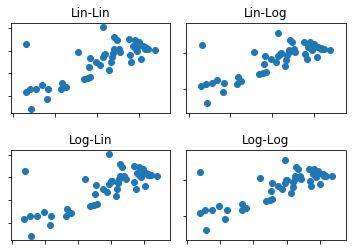

In [15]:
#education
fig=plt.figure()
fig.subplots_adjust(hspace=0.4,wspace=0.1)

ax1=fig.add_subplot(221)
ax1.set_title("Lin-Lin")
ax1.scatter(df["Education"],df["avg grade"])
ax1.set_xticklabels("")
ax1.set_yticklabels("")

ax2=fig.add_subplot(222)
ax2.set_title("Lin-Log")
ax2.scatter(df["Education"],np.log(df["avg grade"]))
ax2.set_xticklabels("")
ax2.set_yticklabels("")

ax3=fig.add_subplot(223)
ax3.set_title("Log-Lin")
ax3.scatter(np.log(df["Education"]),df["avg grade"])
ax3.set_xticklabels("")
ax3.set_yticklabels("")

ax4=fig.add_subplot(224)
ax4.set_title("Log-Log")
ax4.scatter(np.log(df["Education"]),np.log(df["avg grade"]))
ax4.set_xticklabels("")
ax4.set_yticklabels("")
plt.show()

#log-log is the closest one to linearity

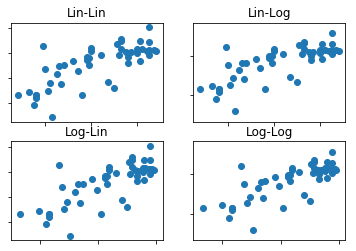

In [16]:
#corruption
fig=plt.figure()

ax1=fig.add_subplot(221)
ax1.set_title("Lin-Lin")
ax1.scatter(df["Corruption"],df["avg grade"])
ax1.set_xticklabels("")
ax1.set_yticklabels("")

ax2=fig.add_subplot(222)
ax2.set_title("Lin-Log")
ax2.scatter(df["Corruption"],np.log(df["avg grade"]))
ax2.set_xticklabels("")
ax2.set_yticklabels("")

ax3=fig.add_subplot(223)
ax3.set_title("Log-Lin")
ax3.scatter(np.log(df["Corruption"]),df["avg grade"])
ax3.set_xticklabels("")
ax3.set_yticklabels("")

ax4=fig.add_subplot(224)
ax4.set_title("Log-Log")
ax4.scatter(np.log(df["Corruption"]),np.log(df["avg grade"]))
ax4.set_xticklabels("")
ax4.set_yticklabels("")
plt.show()

#log-log is the best approximation

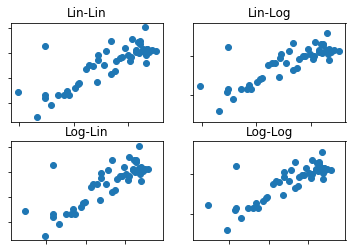

In [17]:
#HDI
fig=plt.figure()

ax1=fig.add_subplot(221)
ax1.set_title("Lin-Lin")
ax1.scatter(df["HDI"],df["avg grade"])
ax1.set_xticklabels("")
ax1.set_yticklabels("")

ax2=fig.add_subplot(222)
ax2.set_title("Lin-Log")
ax2.scatter(df["HDI"],np.log(df["avg grade"]))
ax2.set_xticklabels("")
ax2.set_yticklabels("")

ax3=fig.add_subplot(223)
ax3.set_title("Log-Lin")
ax3.scatter(np.log(df["HDI"]),df["avg grade"])
ax3.set_xticklabels("")
ax3.set_yticklabels("")

ax4=fig.add_subplot(224)
ax4.set_title("Log-Log")
ax4.scatter(np.log(df["HDI"]),np.log(df["avg grade"]))
ax4.set_xticklabels("")
ax4.set_yticklabels("")
plt.show()

#log-log is the best transformation

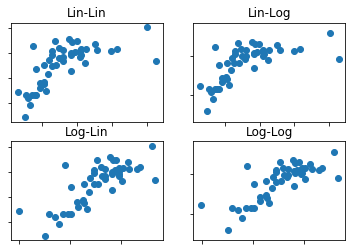

In [18]:
#GDP per Captita
fig=plt.figure()

ax1=fig.add_subplot(221)
ax1.set_title("Lin-Lin")
ax1.scatter(df["GDP per Capita"],df["avg grade"])
ax1.set_xticklabels("")
ax1.set_yticklabels("")

ax2=fig.add_subplot(222)
ax2.set_title("Lin-Log")
ax2.scatter(df["GDP per Capita"],np.log(df["avg grade"]))
ax2.set_xticklabels("")
ax2.set_yticklabels("")

ax3=fig.add_subplot(223)
ax3.set_title("Log-Lin")
ax3.scatter(np.log(df["GDP per Capita"]),df["avg grade"])
ax3.set_xticklabels("")
ax3.set_yticklabels("")

ax4=fig.add_subplot(224)
ax4.set_title("Log-Log")
ax4.scatter(np.log(df["GDP per Capita"]),np.log(df["avg grade"]))
ax4.set_xticklabels("")
ax4.set_yticklabels("")
plt.show()

#log-log is the best aproximation

In [19]:
#creating the model

x=np.log(df[["Education","HDI","GDP per Capita","Corruption"]])
y=np.log(df["avg grade"])

model=sm.OLS(y,sm.add_constant(x))
model=model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              avg grade   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     25.59
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           6.84e-11
Time:                        18:47:35   Log-Likelihood:                 77.401
No. Observations:                  48   AIC:                            -144.8
Df Residuals:                      43   BIC:                            -135.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3874      3.035      1.

In [20]:
#calculating the variance inflation factor(VIF) for the independent variables in the model

vif=pd.DataFrame()
vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif["variable"]=x.columns
vif

,VIF,variable
0,11.032148,Education
1,597.586480,HDI
2,146.144945,GDP per Capita
3,704.041575,Corruption


This is not a good model given that all of the independent variables are not relevant in a 5% significance level, so there are severe problems with the model.
<br>
<br> The first notable error in it is the multicollinearity between the independent variables, given that a warning has been issued and because of the high values for the VIF in multiple variables.
<br>
<br>The multicollinearity comes from the fact that the HDI is an index made using the life expectancy, education and the per capita income indicators, what makes in being correlated with both the education and GDP per Capita indicators. So, the HDI should be deleted from the model.

In [21]:
#creating a new model without HDI
x=np.log(df[["Education","GDP per Capita","Corruption"]])
y=np.log(df["avg grade"])

model=sm.OLS(y,sm.add_constant(x))
model=model.fit()
print(model.summary())

vif=pd.DataFrame()
vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif["variable"]=x.columns
vif

                            OLS Regression Results                            
Dep. Variable:              avg grade   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     34.88
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           1.06e-11
Time:                        18:47:35   Log-Likelihood:                 77.387
No. Observations:                  48   AIC:                            -146.8
Df Residuals:                      44   BIC:                            -139.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.8650      0.168     34.

,VIF,variable
0,5.221133,Education
1,145.685090,GDP per Capita
2,174.596880,Corruption


In the new model corruption still a variable with a high VIF and not relevant, so it should also be excluded from the model

In [22]:
#creating new model without corruption

x=np.log(df[["Education","GDP per Capita"]])
y=np.log(df["avg grade"])

model=sm.OLS(y,sm.add_constant(x))
model=model.fit()
print(model.summary())

vif=pd.DataFrame()
vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif["variable"]=x.columns
vif

                            OLS Regression Results                            
Dep. Variable:              avg grade   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     52.44
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           1.75e-12
Time:                        18:47:35   Log-Likelihood:                 77.047
No. Observations:                  48   AIC:                            -148.1
Df Residuals:                      45   BIC:                            -142.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.9800      0.085     70.

,VIF,variable
0,3.059881,Education
1,3.059881,GDP per Capita


Until this point this point the model looks relevant given that all the predictors are significant and that there is no strong sight of multicollinearity.
<br>
<br> Now the linear regression assumptions must be tested to guarantee that the model is good.

In [23]:
#using sklearn for the model predictions because it has better features

x=np.log(df[["Education","GDP per Capita"]])
y=np.log(df["avg grade"])

model=linear_model.LinearRegression()
model.fit(x,y)

df["predict"]=model.predict(x)
df["res"]=y-df["predict"]

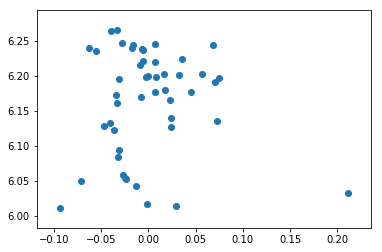

In [24]:
#Testing the linearity assumption

plt.scatter(df["res"],df["predict"])
plt.show()

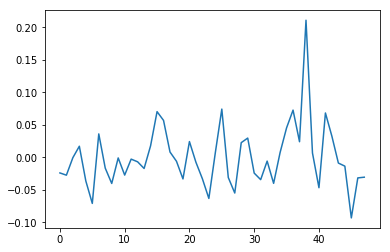

In [25]:
#testing the independence assumption

plt.plot(range(len(df["res"])),df["res"])
plt.show()

Both the graphs for the linearity and independence assumption show that there are outliers.
<br>
<br> Given that the data is relevant for the model and that the information is accurate, the outliers will be kept because some countries have particularities. One example can be Qatar's GDP per Capita which is inflated because the country is an oil exporter with a relatively small population, so their abundant natural resources in a sector that doesn´t need intensive labor led them to higher GDP per Capita.

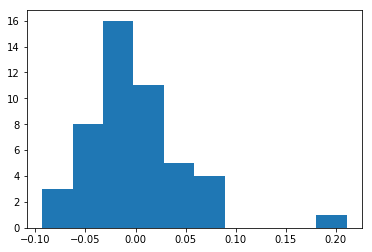

In [26]:
#checking for the residuals normality

plt.hist(df["res"])
plt.show()

The assumption of normality gets verified by the histogram, but again there is one outlier, since this point kept appearing there must be a reason that the model severely underperforms for this point, so further research will be done to explain this country situation.

In [27]:
#identifing the country

df_sorted=df.sort_values(by="res")
df_sorted.tail()

,Country,avg grade,math,read,science,Happiness Score,Region,Hemisphere,HDI,Beer per Capita,Education,Corruption,GDP per Capita,predict,res
41,Singapore,551.62,564.19,535.10,555.57,6.798,Southeastern Asia,North,930,60,0.814,85,100.345,6.244650,0.068209
15,Estonia,524.29,519.53,519.14,534.19,5.429,Central and Eastern Europe,North,868,224,0.877,73,34.096,6.191768,0.070277
36,Portugal,496.95,491.63,498.13,501.10,5.102,Western Europe,North,845,194,0.756,64,32.006,6.135860,0.072629
25,Japan,528.93,532.44,515.96,538.39,5.987,Eastern Asia,North,907,77,0.842,73,44.227,6.196649,0.074207
38,China,514.34,531.30,493.94,517.78,5.140,Eastern Asia,North,748,79,0.631,39,18.110,6.031923,0.210961


After further analysis the country that severely outperformed the model was China, so we will dive deep into its characteristics to see why this happened.
<br>
<br>The first significant factor is that the data from China only comes from four different provinces / municipalities: Beijing, Guangdong, Jiangsu and Shanghai, while other provinces also take the test, their results are not disclosed for the general public because the government don't allow the publication. A significant factor in these areas where the results were published is that these are economic powerhouses. Taking by example Shanghai which has better educational and economic indicators than the rest of China.
<br>
<br> Another significant factor is that the Chinese education system focus heavily into preparing students for test taking over acquiring practical knowledge and abilities. This led to a culture where achieving high grades is a must and drives parents to invest into their children's education outside of school. The result of this is that China can achieve high grades in the test while maintaining worst general indicators.
<br>
<br>For this reasons, the Chinese grade in the Pisa test can be described as biased, because only the results of the socioeconomic elite of the country is in the test. Consequently this result cannot be compared to the other countries where the sample includes multiple different backgrounds, leading to a grade more similar to reality. Thus the Chinese grade can be considered a wrong measure and can be deleted from the data so the model can be more precise and adequate.

In [28]:
#new database without china
df_china=df[df["Country"] != "China"]

#creating the new model without the chinese data

x=np.log(df_china[["Education","GDP per Capita"]])
y=np.log(df_china["avg grade"])

model=sm.OLS(y,sm.add_constant(x))
model=model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              avg grade   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     108.3
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           1.02e-17
Time:                        18:47:36   Log-Likelihood:                 88.867
No. Observations:                  47   AIC:                            -171.7
Df Residuals:                      44   BIC:                            -166.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.0275      0.065     93.

After deleting China from the database the model improves a significant amount, what can be seen in by a increased R-squared, showing that excluding China from the model was a good idea.

## Conclusion

<br> The final model is:

$$ ln(PisaGrade)=0.4650*ln(Education) + 0.0653*ln(GDP per Capita)+6.0275 $$

From the model we can conclude that a country without GDP expected Pisa grade would be 414.67 ($ e^{6.0275} $), a grade that would put the country between the worst performing countries. An 1% increase in Education would result in an expected 1.59 increase in the grade, while and 1% increase in GDP per Capita would result in an expected 1.06 increase in the grade.
<br>
<br>The regression model shows that while increasing GDP per Capita is a valid way to increase the country performance, direct investments into improving the education is the best way to increase the result. This shows that direct investments into education are the best way to increase the grade, but investments into developing the socioeconomic environment is also a valid way to improve results, showing that better economical, political and social indexes carry over to better education.
<br>
<br>Another conclusion that can be infered from this project is that the high performing countries in the Pisa test are not the ones with the best education index, but the ones that have a good education combined with high GDP per Capita. The explanation for this comes from two main factors: that students with enough familiar income can focus on their studies without the need for working to support their families, and because higher education quality can be a sign of better schooling systems, the example of this is Eastern Asia, the best performing region in the test.

# Resources

https://www.brookings.edu/research/pisas-china-problem/
<br>http://www.sixthtone.com/news/1659/outside-shanghai%2C-china-fails-to-ace-pisa-test/
<br>https://www.oecd.org/pisa/PISA-2015-china.pdf